In [1]:


from fastai.vision.all import *
import torchaudio
import pathlib
import librosa
from IPython.display import Audio
import librosa.display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
%config Completer.use_jedi = False



/home/john/.virtualenvs/data_science_testing2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/john/.virtualenvs/data_science_testing2/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
mypath = "/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = get_files(mypath, extensions='.wav')
filenames

(#920) [Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/223_1b1_Ar_sc_Meditron.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/133_2p2_Tc_mc_AKGC417L.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/109_1b1_Pl_sc_Litt3200.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Pr_sc_Litt3200.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/188_1b1_Tc_sc_Meditron.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/203_1p3_Ar_mc_AKGC417L.wav'),Path('/home/john/Downloads/kaggle_respiratory_data/Respiratory_Sound

In [3]:
p_diag = pd.read_csv("/home/john/Downloads/kaggle_respiratory_data/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file
p_diag.head()

,0,1
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
n_fft=1024
hop_length=256
target_rate=44100
num_samples=int(target_rate)

In [5]:
## Method for labelling sample (Healthy/Unhealthy)
def get_y(path): 
    desease = p_diag[p_diag[0] == int(path.stem[:3])][1].values[0]
    if desease == "Healthy":
        return "Healthy"
    else : 
        return "Unhealthy"

In [6]:


## Method for getting all audio files, I get file withc rate 44100 Hz only because resampling take so much time :( 
def get_items(path): 
    fns = [fn for fn in get_files(path, extensions='.wav') if torchaudio.load_wav(fn)[1] == target_rate]
    return fns



In [7]:


## Helper method to tranform audio array to Spectrogram
au2spec = torchaudio.transforms.MelSpectrogram(sample_rate=target_rate,n_fft=n_fft, hop_length=hop_length, n_mels=256)
ampli2db = torchaudio.transforms.AmplitudeToDB()



In [8]:
def get_x(path, target_rate=target_rate, num_samples=num_samples*2):
    x, rate = torchaudio.load_wav(path)
    if rate != target_rate: 
        x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=target_rate, resampling_method='sinc_interpolation')(x)
    x = x[0] / 32768
    x = x.numpy()
    sample_total = x.shape[0]
    randstart = random.randint(target_rate, sample_total-target_rate*3)
    x = x[randstart:num_samples+randstart]
    x = librosa.util.fix_length(x, num_samples)
    torch_x = torch.tensor(x)
    spec = au2spec(torch_x)
    spec_db = ampli2db(spec)
    spec_db = spec_db.data.squeeze(0).numpy()
    spec_db = spec_db - spec_db.min()
    spec_db = spec_db/spec_db.max()*255
    return spec_db

In [9]:
## Getting all files and labels
items = get_items(mypath)
labels = [get_y(item) for item in items]
Counter(labels)

Counter({'Unhealthy': 789, 'Healthy': 35})

In [10]:
test_size=0.3
splitter = TrainTestSplitter(test_size=test_size, random_state=42, stratify=labels)


In [11]:


db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=[Resize(256)])



In [12]:


dsets = db.datasets(items)



In [13]:


dsets



(#824) [(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1)),(PILImage mode=F size=345x256, TensorCategory(1))...]

In [14]:
count = Counter(labels)
wgts = [1/count[dsets.vocab[label]] for img, label in dsets.train]
wgts[:10]

[0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.02857142857142857,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308,
 0.0012674271229404308]

In [15]:
dls = db.dataloaders(items, num_workers=2, dl_type=WeightedDL, wgts=wgts)

In [16]:
x, y = dls.one_batch()

In [17]:
sum(y)/len(y)

tensor(0.4375)

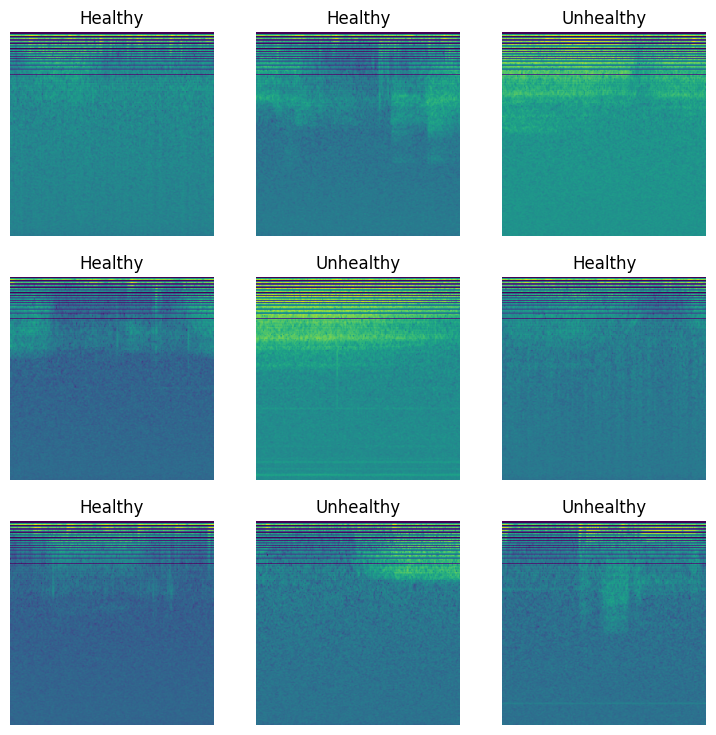

In [18]:
dls.show_batch()

In [19]:


## We use xresnet18 as model
# learn = cnn_learner(dls, xresnet18, metrics=error_rate, n_in=3)
learn = cnn_learner(dls, xresnet18, metrics=error_rate, n_in=1)

# model = resnet34(pretrained=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# learn = cnn_learner(dls, model, metrics=error_rate)


In [20]:
learn.fine_tune(1)

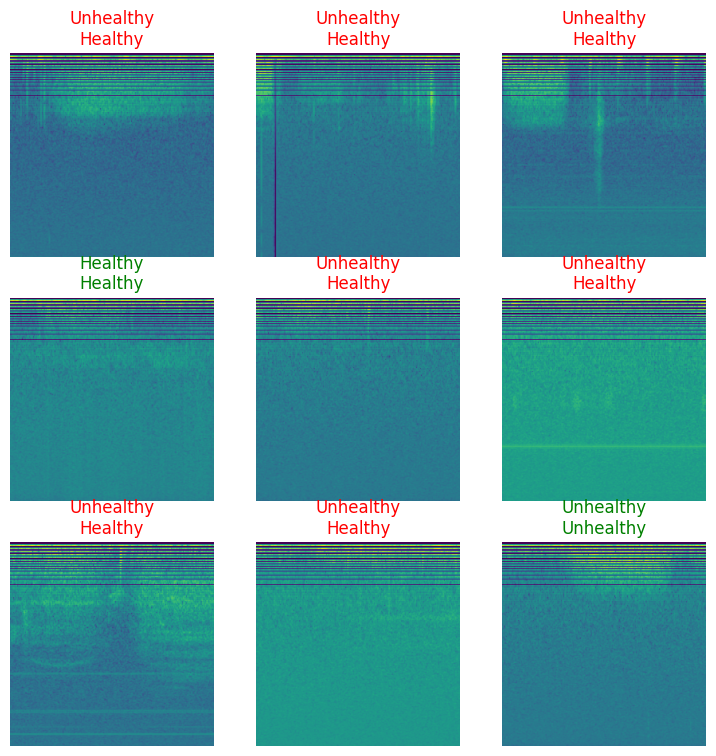

In [21]:


learn.show_results()



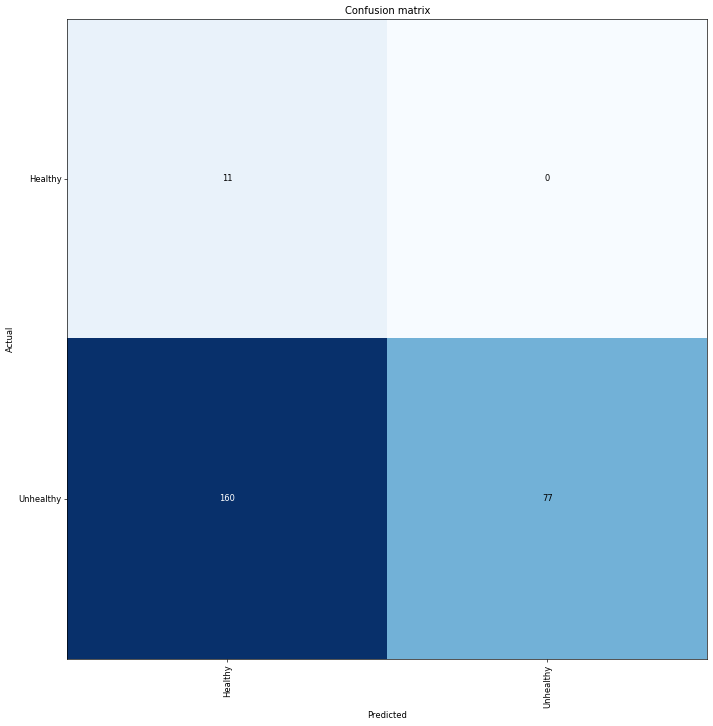

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)